# **Mining of large datasets - Project**
## Deep Learning approach using RoBERTa to classify the SST-5 dataset



In [5]:
#Install required packages (if needed)
! pip install transformers
! pip install imbalanced-learn
! pip install timebudget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 30.7 MB/s 
     |████████████████████████████████| 7.6 MB 26.7 MB/s 
     |████████████████████████████████| 182 kB 79.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import required libraries

In [6]:
#Import required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.optim import AdamW
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
from transformers import RobertaForSequenceClassification, RobertaConfig

from timebudget import timebudget
timebudget.report_atexit()  # Generate report when the program exits

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# Load datasets (train, validation and testing)

We have included a zip file containing the datasets.

In [7]:
#Load training, validation and testing datasets
train_dataset = pd.read_csv('./train.txt', sep="\t", header=None, names=["label", "data"])
validation_dataset = pd.read_csv('./dev.txt', sep="\t", header=None, names=["label", "data"])
test_dataset = pd.read_csv('./test.txt', sep="\t", header=None, names=["label", "data"])

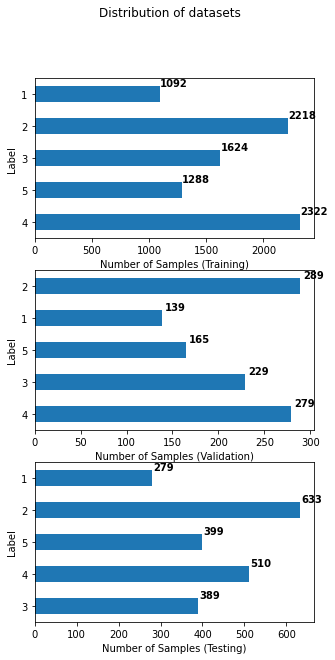

In [14]:
#Explore distribution of datasets

fig, ax = plt.subplots(3, figsize=(5,10))
fig.suptitle('Distribution of datasets')

#Training data
ax[0] = train_dataset['label'].value_counts(sort=False).plot(kind='barh', ax=ax[0])
ax[0].set_xlabel('Number of Samples (Training)')
ax[0].set_ylabel('Label')

for i, v in enumerate(train_dataset['label'].value_counts(sort=False)):
    ax[0].text(v + 3, i + .25, str(v), fontweight='bold')

# #Validation data
ax[1] = validation_dataset['label'].value_counts(sort=False).plot(kind='barh', ax=ax[1])
ax[1].set_xlabel('Number of Samples (Validation)')
ax[1].set_ylabel('Label')

for i, v in enumerate(validation_dataset['label'].value_counts(sort=False)):
    ax[1].text(v + 3, i + .25, str(v), fontweight='bold')

# #Testing data
ax[2] = test_dataset['label'].value_counts(sort=False).plot(kind='barh', ax=ax[2])
ax[2].set_xlabel('Number of Samples (Testing)')
ax[2].set_ylabel('Label')

for i, v in enumerate(test_dataset['label'].value_counts(sort=False)):
    ax[2].text(v + 3, i + .25, str(v), fontweight='bold')

# Balancing datasets

To deal with unbalanced data we will oversample and undersample the datasets

In [ ]:
#Oversampling minority classes
c0 = train_dataset[train_dataset['label'] == 1]
c1 = train_dataset[train_dataset['label'] == 2]
c2 = train_dataset[train_dataset['label'] == 3]
c3 = train_dataset[train_dataset['label'] == 4]
c4 = train_dataset[train_dataset['label'] == 5]

max_count = train_dataset.label.value_counts().max()

over_c0 = c0.sample(max_count, replace='True')
over_c1 = c1.sample(max_count, replace='True')
over_c2 = c2.sample(max_count, replace='True')
over_c4 = c4.sample(max_count, replace='True')

oversampled_train_dataset = pd.concat([over_c0,over_c1, over_c2, c3, over_c4], axis=0)

#Undersampling majority classes
min_count = train_dataset.label.value_counts().min()
under_c1 = c1.sample(min_count)
under_c2 = c2.sample(min_count)
under_c3 = c3.sample(min_count)
under_c4 = c4.sample(min_count)

undersampled_train_dataset = pd.concat([c0,under_c1, under_c2, under_c3, under_c4], axis=0)

print('Oversampled dataset: \n', oversampled_train_dataset.label.value_counts())

print('Undersampled dataset: \n', undersampled_train_dataset.label.value_counts())

Oversampled dataset: 
 1    2322
2    2322
3    2322
4    2322
5    2322
Name: label, dtype: int64
Undersampled dataset: 
 1    1092
2    1092
3    1092
4    1092
5    1092
Name: label, dtype: int64


In [ ]:
#Define architecture of RoBERTa model

class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, n_classes, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        # config = RobertaConfig.from_pretrained('roberta-base')
        # config.num_labels = n_classes
        # self.roberta = RobertaForSequenceClassification.from_pretrained('roberta-base', config=config)

        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, n_classes)
        
    def forward(self, input_ids, attention_mask):

        # x = self.roberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)[0]

        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)

        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)

        x = self.l2(x)
        # x = F.softmax(self.l2(x), dim=1)
        return x

In [ ]:
#Get the number of classes
n_classes = train_dataset['label'].nunique()
print('N classes: ', n_classes)

model = ROBERTAClassifier(n_classes)

N classes:  5


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [ ]:
def prepare_features(review, zero_pad = False, max_seq_length = 512):
    
    enc_text = tokenizer.encode_plus(text=review, add_special_tokens=True, max_length=max_seq_length, padding='max_length', truncation=True)
    return enc_text

In [ ]:
example_review = train_dataset.loc[0]['data']
print(example_review)
enc_example = prepare_features(example_review)
print(enc_example)
print(len(enc_example['input_ids']))

The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
{'input_ids': [0, 133, 2751, 16, 19083, 7, 28, 5, 733, 620, 9348, 128, 29, 92, 45518, 38650, 12801, 8, 14, 37, 128, 29, 164, 7, 146, 10, 17158, 190, 2388, 87, 11816, 28797, 2156, 5363, 12, 11428, 5247, 3415, 8234, 1794, 50, 5031, 1608, 9487, 479, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
#Class to prepare X and Y data
class Format_Data(Dataset):
    def __init__(self, dataframe):
        self.len = len(dataframe)
        self.data = dataframe
        
    def __getitem__(self, index):

        review = self.data['data'].iloc[index]

        X = prepare_features(review)

        #Transform current classes [1,2,3,4,5] to [0,1,2,3,4]
        y = self.data['label'].iloc[index] - 1
        
        return np.array(X['input_ids']), np.array(X['attention_mask']), np.array(y)
    
    def __len__(self):
        return self.len

In [ ]:
training_set = Format_Data(train_dataset)
# oversampled_training_set = Format_Data(oversampled_train_dataset)
# undersampled_training_set = Format_Data(undersampled_train_dataset)

validation_set = Format_Data(validation_dataset)


In [ ]:
testing_set = Format_Data(test_dataset)

In [ ]:
### Dataloaders Parameters
params = {'batch_size': 8}


# Training using undersampled/oversampled/original dataset

In [ ]:
# u_training_loader = DataLoader(undersampled_training_set, **params)
# o_training_loader = DataLoader(oversampled_training_set, **params)
training_loader = DataLoader(training_set, **params)
validation_loader = DataLoader(validation_set, **params)


In [ ]:
testing_loader = DataLoader(testing_set, **params)

In [ ]:
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-5
optimizer = optim.AdamW(params=model.parameters(), betas=(0.9, 0.98), lr=learning_rate)

if torch.cuda.is_available():
    print("GPU is AVAILABLE!🤘🙌💪")
    model = model.cuda()

GPU is AVAILABLE!🤘🙌💪


In [ ]:
from sklearn.metrics import f1_score

@timebudget
def train(model, epochs, training_loader_):
  best_accuracy = 0.0 
  max_epochs = epochs
  for epoch in tqdm_notebook(range(max_epochs)):

      train_loss = 0.0
      model.train()
      correct = 0
      total = 0
      for i, (ids, attention_mask, labels) in enumerate(training_loader_):

          optimizer.zero_grad()
          if torch.cuda.is_available():
              ids = ids.cuda()
              attention_mask = attention_mask.cuda()
              labels = labels.cuda()

          output = model.forward(ids, attention_mask=attention_mask)

          loss = loss_function(output, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

          #Output acc every 100
          _, predicted = torch.max(output, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          accuracy = 100.00 * correct / total

          if i%100 == 0:
              print('Iteration: {}. Loss: {}. Training Accuracy: {}.%'.format(i, loss.item(), accuracy))

      #Calculate training accuracy and loss
      final_t_accuracy = 100.00 * correct / total
      avg_t_loss = train_loss / len(training_loader_)
        
      #Validation loop
      valid_loss = 0.0
      correct = 0
      total = 0

      with torch.no_grad():
          model.eval()
          for i, (ids, attention_mask, labels) in enumerate(validation_loader):

              if torch.cuda.is_available():
                  ids = ids.cuda()
                  attention_mask = attention_mask.cuda()
                  labels = labels.cuda()
          
              output = model.forward(ids, attention_mask=attention_mask)
              loss = loss_function(output, labels)
              valid_loss += loss.item()

              _, predicted = torch.max(output, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
              accuracy = 100.00 * correct / total

              if i%100 == 0:
                  print('Iteration: {}. Loss: {}. Validation Accuracy: {}.%'.format(i, loss.item(), accuracy))

      #Calculate validation accuracy and loss
      final_v_accuracy = 100.00 * correct / total
      avg_v_loss = valid_loss / len(validation_loader)

      #Report results per epoch
      print(f'Epoch {epoch} \t Training Loss: {avg_t_loss} \t Training Accuracy: {final_t_accuracy} \t Validation Loss: {avg_v_loss} \t Validation Accuracy: {final_v_accuracy}')

      # Save the model if the accuracy is the best 
      if final_v_accuracy > best_accuracy: 
            print(f'Accuracy increased({best_accuracy:.6f}--->{final_v_accuracy:.6f}) \t Saving The Model')
            best_accuracy = final_v_accuracy
            torch.save(model.state_dict(), './mymodel.pt')                    
  
  return "Training finished!"

In [ ]:
train(model, 5, training_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/5 [00:00<?, ?it/s]

Iteration: 0. Loss: 1.9123878479003906. Training Accuracy: 0.0.%
Iteration: 100. Loss: 1.4801982641220093. Training Accuracy: 42.82178217821782.%
Iteration: 200. Loss: 1.0363661050796509. Training Accuracy: 45.646766169154226.%
Iteration: 300. Loss: 0.8117481470108032. Training Accuracy: 47.79900332225914.%
Iteration: 400. Loss: 1.1208134889602661. Training Accuracy: 49.781795511221944.%
Iteration: 500. Loss: 1.4582126140594482. Training Accuracy: 50.424151696606785.%
Iteration: 600. Loss: 1.137970209121704. Training Accuracy: 48.48169717138103.%
Iteration: 700. Loss: 1.7825311422348022. Training Accuracy: 48.44864479315264.%
Iteration: 800. Loss: 1.1688129901885986. Training Accuracy: 48.36142322097378.%
Iteration: 900. Loss: 1.3552838563919067. Training Accuracy: 48.46004439511654.%
Iteration: 1000. Loss: 1.305487036705017. Training Accuracy: 48.57642357642358.%
Iteration: 0. Loss: 1.6790359020233154. Validation Accuracy: 25.0.%
Iteration: 100. Loss: 1.0806810855865479. Validation Ac

'Training finished!'

In [ ]:
#Load best model
model.load_state_dict(torch.load('./mymodel.pt'))
model.eval()

ROBERTAClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

# Testing the model

In [ ]:
@timebudget
def test(model):

    y_test = []
    y_pred = []

    correct = 0
    total = 0
    for i, (ids, attention_mask, labels) in enumerate(testing_loader):
        if torch.cuda.is_available():
            ids = ids.cuda()
            attention_mask = attention_mask.cuda()
            labels = labels.cuda()
        
        output = model.forward(ids,attention_mask=attention_mask)

        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100.00 * correct / total

        y_test.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

        if i%100 == 0:      
            print('Iteration: {}. Accuracy: {}%'.format(i, accuracy))


    accuracy = 100.00 * correct / total
    print('Final Accuracy: ', accuracy)
    print('F1 score macro: ', f1_score(y_test, y_pred, average='macro'))
    print('F1 score micro: ', f1_score(y_test, y_pred, average='micro'))

In [ ]:
#Testing
test(model)

Iteration: 0. Accuracy: 37.5%
Iteration: 100. Accuracy: 50.742574257425744%
Iteration: 200. Accuracy: 51.92786069651741%
Final Accuracy:  51.90045248868778
F1 score macro:  0.5021061884643802
F1 score micro:  0.5190045248868779
test took 69.511sec
